In [1]:
import sys
sys.path.append("../")
import os, os.path as osp
import numpy as np
from typing import List, Dict, Union
from collections import namedtuple
import torch
import torch.nn as nn
import torch.functional as F
import cv2
import matplotlib.pyplot as plt
import time

import mcubes
from IPython.core.debugger import set_trace

/home/ayush/projects/nerf/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
device='cuda'

# Positional Encodings

In [4]:


# def get_coordinate_distance(side: float, 
#                             u: np.ndarray,
#                             v: np.ndarray):
#     x = np.array([np.floor(u/side), np.ceil(u/side) ])
#     y = np.array([np.floor(v/side), np.ceil(v/side) ])
#     print(x, y)
#     mx, my  = np.meshgrid(x, y)
#     d = np.sqrt( (mx - u)**2 + (my - v)**2)
#     sorrounding = np.vstack([mx.flatten(), my.flatten()]).T
#     print(sorrounding.shape)
#     return d.flatten(), sorrounding
    
                 
# get_coordinate_distance(2, 3.7, 2.4)

In [5]:
class MultiResHashEncoding(nn.Module):
    
    def __init__(self, L=16, T=2**14, F=2, Nmin=16, Nmax=512, device='cpu'):
        super(MultiResHashEncoding, self).__init__()
        self.growth_factor = np.exp((np.log(Nmax) - np.log(Nmin))/(L - 1))
        self.levels = torch.arange(0, L, device=device)
        self.levels = Nmin * self.growth_factor ** self.levels
        self.hash_tables = nn.Parameter(torch.zeros(L, T, F), requires_grad=True).to(device) # L, T, F        
        
        self.L = L
        self.T = T
        self.F = F
        self.Nmin = Nmin
        self.Nmax = Nmax
        self.device = device
        
        # Paper uses three prime numbers for 3 dimesnional points
        self.primes = torch.tensor([1, 2654435761, 805459861]).to(int).to(device)
        
        # The hash table is initialized using uniform in -10e-4, 10e-4
        for param in self.hash_tables:
            if isinstance(param, nn.Parameter):
                nn.init.uniform_(param, -10e-4, 10e-4)        
        
    
    
    def forward(self, xyz_p):                                
        """
        xyz_p: ray points
        xyz_d: ray_directions
        """
        # tic = time.time()
        xyz_en = self.get_multires_hash_encoding(xyz_p)
        # toc = time.time()
        # print(f"MHRE time: {(toc - tic)* 1000} ms")
        return xyz_en
        pass
    
    def get_multires_hash_encoding(self, pts): 
        BS = pts.shape[0]
        pos_embed = torch.zeros((L, BS, 2), device=self.device)
        level_encodings = []
        for level in range(self.L):
            # scale the points by the growth
            pL = self.levels[level] * pts # Bs, 3
            
            # Find the floor and ceil for the points
            fpL = torch.floor(pL) # Bs, 3
            cpL = torch.ceil(pL)  # Bs, 3
            
            # Find 8 neighbours of the point in 3D grid
            nbrs = self.get_neighbours(fpL, cpL)            # Nbrs: Bs, 8, 3
            # print(f"neigbors: {nbrs.shape}")
            
            # find distance from each of these neighbours
            dist = (nbrs - pts.unsqueeze(1)).norm(dim=-1)   # Dist: Bs, 8
            # print(f"dist: {dist.shape}")
            
            # Get the hashed value of the neighbour
            hashed_nbrs = self.hash_function(nbrs.reshape(-1, 3), level) #Bs * 8, 2
            hashed_nbrs = hashed_nbrs.reshape(BS, -1, F)          # Bs, 8, 2              
            # print(f"hashed_neighbour: {hashed_nbrs.shape}")
            
            # Interoloate the coordinates. Using vanilla interpolation
            interpolated_coords = (hashed_nbrs * dist.unsqueeze(-1)).sum(1)
            # print(interpolated_coords.shape)
            
            pos_embed[level] = interpolated_coords
        
        pos_embed = pos_embed.transpose(0,1).reshape(BS, -1)
        return pos_embed
            
            
    def get_neighbours(self, fpL, cpL):
        neighbours = torch.zeros((fpL.shape[0], 8, 3), device=self.device)
        idxs = torch.tensor([[0,0,0],
                             [0,0,1],
                             [0,1,0],
                             [0,1,1],
                             [1,0,0],
                             [1,0,1],
                             [1,1,0],
                             [1,1,1],
                            ], device=self.device)
        # Expand the dimensions of fpL and cpL to match the shape of idxs
        expanded_fpL = fpL[:, None, :]
        expanded_cpL = cpL[:, None, :]

        # Calculate the neighboring points using fpL, cpL, and idxs
        neighbor_coords = expanded_fpL + idxs * (expanded_cpL - expanded_fpL)
        return neighbor_coords.to(int)
                                
            
            
    def hash_function(self, key, level): #N, 3
        # Hash function implementation
        hashed_key = key *  self.primes
        hashed_key = torch.bitwise_xor(hashed_key[:, 0], torch.bitwise_xor(hashed_key[:, 1], hashed_key[:, 2])) % self.T
        result = self.hash_tables[level][hashed_key]
        return result
            
            
            
                          
            
                        
    
# L = 16
# T = 2 ** 14
# F = 2
# Nmin = 16
# Nmax = 512
# pe = MultiResHashEncoding(L, T, F, Nmin, Nmax)
# pts = torch.randn((1024 * 100,3))
# pe(pts).shape
        
        
        
        
        

# Spherical Harmonics encoding

In [6]:
def components_from_spherical_harmonics(
    levels: int, directions
):
    """
    Returns value for each component of spherical harmonics.

    Args:
        levels: Number of spherical harmonic levels to compute.
        directions: Spherical harmonic coefficients
    """
    num_components = levels**2
    components = torch.zeros((*directions.shape[:-1], num_components), device=directions.device)

    assert 1 <= levels <= 5, f"SH levels must be in [1,4], got {levels}"
    assert directions.shape[-1] == 3, f"Direction input should have three dimensions. Got {directions.shape[-1]}"

    x = directions[..., 0]
    y = directions[..., 1]
    z = directions[..., 2]

    xx = x**2
    yy = y**2
    zz = z**2

    # l0
    components[..., 0] = 0.28209479177387814

    # l1
    if levels > 1:
        components[..., 1] = 0.4886025119029199 * y
        components[..., 2] = 0.4886025119029199 * z
        components[..., 3] = 0.4886025119029199 * x

    # l2
    if levels > 2:
        components[..., 4] = 1.0925484305920792 * x * y
        components[..., 5] = 1.0925484305920792 * y * z
        components[..., 6] = 0.9461746957575601 * zz - 0.31539156525251999
        components[..., 7] = 1.0925484305920792 * x * z
        components[..., 8] = 0.5462742152960396 * (xx - yy)

    # l3
    if levels > 3:
        components[..., 9] = 0.5900435899266435 * y * (3 * xx - yy)
        components[..., 10] = 2.890611442640554 * x * y * z
        components[..., 11] = 0.4570457994644658 * y * (5 * zz - 1)
        components[..., 12] = 0.3731763325901154 * z * (5 * zz - 3)
        components[..., 13] = 0.4570457994644658 * x * (5 * zz - 1)
        components[..., 14] = 1.445305721320277 * z * (xx - yy)
        components[..., 15] = 0.5900435899266435 * x * (xx - 3 * yy)

    # l4
    if levels > 4:
        components[..., 16] = 2.5033429417967046 * x * y * (xx - yy)
        components[..., 17] = 1.7701307697799304 * y * z * (3 * xx - yy)
        components[..., 18] = 0.9461746957575601 * x * y * (7 * zz - 1)
        components[..., 19] = 0.6690465435572892 * y * (7 * zz - 3)
        components[..., 20] = 0.10578554691520431 * (35 * zz * zz - 30 * zz + 3)
        components[..., 21] = 0.6690465435572892 * x * z * (7 * zz - 3)
        components[..., 22] = 0.47308734787878004 * (xx - yy) * (7 * zz - 1)
        components[..., 23] = 1.7701307697799304 * x * z * (xx - 3 * yy)
        components[..., 24] = 0.4425326924449826 * (xx * (xx - 3 * yy) - yy * (3 * xx - yy))

    return components

# pts = torch.randn(30, 3)
# components_from_spherical_harmonics(4, pts).shape

 # Model

In [7]:
class NGP_MLP(nn.Module):
    
    def __init__(self, L=16, T=2 ** 14, F=2, Nmin=16, Nmax=512, sph_coeff=4, hidden_dim=64, device='cpu'):
        super(NGP_MLP, self).__init__()
        self.sigma_block = nn.Sequential( nn.Linear(L* F, hidden_dim), nn.ReLU(),
                                       nn.Linear(hidden_dim, 16)
                                    ).to(device)
        self.rgb_block = nn.Sequential(nn.Linear(16 + 16, hidden_dim), nn.ReLU(),
                                         nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                         nn.Linear(hidden_dim, 3)
                                        ).to(device=device)
        
        self.mrhe = MultiResHashEncoding(L, T, F, Nmin, Nmax, device)
        self.L = L
        self.T = T
        self.F = F
        self.Nmin = Nmin
        self.Nmax = Nmax
        self.sph_coeff=sph_coeff
        self.hidden_dim = hidden_dim
        self.device = device
        
        for _, param in self.sigma_block.named_parameters():
            if isinstance(param, nn.Linear):
                nn.init.xavier_uniform_(param.weight)
                if param.bias is not None:
                    nn.init.zeros_(param.bias)
                
        
    def forward(self, xyz_p, xyz_d):
        """
        xyz_p: N, 3 points sampled
        xyz_d: N, 3 direction vectors. Make sure, they are normalized
        """
        
        xyz_p_em = self.mrhe(xyz_p).to(self.device)
        xyz_d_em = components_from_spherical_harmonics(self.sph_coeff, xyz_d).to(self.device)
        
        out = self.sigma_block(xyz_p_em)
        sigma = out[:, -1]
        color = self.rgb_block(torch.cat([out, xyz_d_em], dim=-1))
        return torch.sigmoid(color), torch.relu(sigma)

    def intersect(self, xyz_p, xyz_d):
        return self.forward(xyz_p, xyz_d)
    
# L = 16
# T = 2 ** 14
# F = 2
# Nmin = 16
# Nmax = 512
# sph_coeff = 4
# hidden_dim = 64
# ngp = NGP_MLP( L, T, F, Nmin, Nmax, sph_coeff, hidden_dim, device=device)


# Rendering

In [8]:
from src.utils.render import render, accumulated_transmittance, find_t0_for_image

In [9]:
def render_with_perturbation(model: nn.Module,
           rays_o: np.ndarray,
           rays_d: np.ndarray,
           tn: float,
           tf: float,
           num_bins=100,
           device='cpu',
           directional_input=True,
           white_bgr=True):
    """
    Assigns color values to each ray
    :param model: A model to represent the 3D shape
    :param rays_o: Origin of rays coming from camera
    :param rays_d: Direction of rays coming from camera
    :param tn: initial query time
    :param tf: final query time. We will integreate bw tn, tf
    :param num_bins: the num of bins to divide this query window in
    :param device: {cuda, cpu}
    :param white_bckgr: if the image has a white background
    :return:
    """

    num_points = rays_o.shape[0]
    if isinstance(rays_o, np.ndarray):
        rays_o = torch.from_numpy(rays_o).float().to(device=device)
    if isinstance(rays_d, np.ndarray):
        rays_d = torch.from_numpy(rays_d).float().to(device=device)
    t = torch.linspace(tn, tf, num_bins).to(device=device).expand(rays_o.shape[0], num_bins)  # Npts, nbins
    # Perturb sampling along each ray.
    mid = (t[:, :-1] + t[:, 1:]) / 2.
    lower = torch.cat((t[:, :1], mid), -1)
    upper = torch.cat((mid, t[:, -1:]), -1)
    u = torch.rand(t.shape, device=device)
    t = lower + (upper - lower) * u  # [batch_size, nb_bins]
    delta = torch.cat((t[:, 1:] - t[:, :-1], torch.tensor([1e10], device=device).expand(rays_o.shape[0], 1)), -1)

    r = rays_o.unsqueeze(1) + t.unsqueeze(2) * rays_d.unsqueeze(1)  # [batch_size, nb_bins, 3]
    if directional_input:
        colors, density = model.intersect(r.reshape(-1, 3),
                                          rays_d.expand(num_bins, num_points, 3).transpose(0, 1).reshape(-1, 3))
    else:
        colors, density = model.intersect(r.reshape(-1, 3))

    density = density.reshape(num_points, num_bins)  # density: Npts, Nbins
    colors = colors.reshape(num_points, num_bins, 3)  # colors: Npts , Nbins, 3
    alpha = 1. - torch.exp(- density * delta)  # Npts, Nbins
    weights = accumulated_transmittance(1 - alpha).unsqueeze(2) * alpha.unsqueeze(2)

    if white_bgr:
        c = (weights * colors).sum(1)  # [nb_rays, 3]
        weight_sum = weights.sum(-1).sum(-1)  # [nb_rays]
        return c + 1 - weight_sum.unsqueeze(-1)
    else:
        c = (weights * colors).sum(1)  # [nb_rays, 3]
    return c


def batchify_image_and_render(model: nn.Module,
                              rays_o: np.ndarray,
                              rays_d: np.ndarray,
                              tn: float,
                              tf: float,
                              num_bins: int=100,
                              reduction_factor:int=128,
                              directional_input=True,
                              device='cpu',
                              white_bgr=True) -> np.ndarray:
    """

    :param model: A model to represent the 3D shape
    :param rays_o: Origin of rays coming from camera
    :param rays_d: Direction of rays coming from camera
    :param tn: initial query time
    :param tf: final query time. We will integreate bw tn, tf
    :param reduction_factor: Divides the total points by this factor
    :param num_bins: the num of bins to divide this query window in
    :param device: {cuda, cpu}
    :param white_bckgr: if the image has a white background
    :return:
    """
    with torch.no_grad():
        npts = rays_o.shape[0]
        assert npts % reduction_factor == 0
        batch_o = rays_o.reshape(-1, npts//reduction_factor, 3)
        batch_d = rays_d.reshape(-1, npts//reduction_factor, 3)
        if isinstance(rays_o, np.ndarray):
            Ax = np.zeros_like(batch_o)
        else:
            Ax = torch.zeros_like(batch_o)
        for i in range(batch_o.shape[0]):
            Ax[i] = render(model,
                           batch_o[i],
                           batch_d[i],
                           tn=tn,
                           tf=tf,
                           num_bins=num_bins,
                           device=device,
                           directional_input=directional_input,
                           white_bgr=white_bgr).detach().cpu()
        if isinstance(Ax, np.ndarray):
            return Ax.reshape(-1, 3)
        return Ax.reshape(-1, 3).cpu().numpy()

# Generating Experiment Session

In [10]:
Session = namedtuple('Session', ['sess_dir', 't_started'])

def generate_new_session(root, obj=None):
    from datetime import datetime
    dt = datetime.now()
    dt_str = dt.strftime("%Y-%m-%d %H:%M:%S") # Convert datetime to a string
    if obj is None:
        obj = ""
    sess_dir = osp.join(root, f"exp-{obj}-{dt_str}")
    if not osp.exists(sess_dir):
        os.makedirs(sess_dir, exist_ok=True)
    session = Session(sess_dir, dt)
    return session

def save_model(sess, model, epoch):
    modelpath = osp.join(sess.sess_dir, f"epoch-{epoch}")
    torch.save(model.cpu(), modelpath)

# Train on Lego 100x100

## Load the Lego Dataset

In [11]:
from src.utils.dataset.lego_dataset import create_rays

obj = "lego"
H = W = 100
root = f"../data/{obj}"

focal = np.load(osp.join(root, "focal.npy"))
poses = np.load(osp.join(root, "poses.npy"))
imgs = np.load(osp.join(root, "images.npy"))

print(imgs.shape, poses.shape)
o, d, imgt = [], [], []
N = len(imgs)
for i in range(N):
    o_, d_ = create_rays(imgs[i], poses[i], focal)
    o.append(o_)
    d.append(d_)
    imgt.append(imgs[i].reshape(-1, 3))
    
o = np.array(o)
d = np.array(d)
imgt = np.array(imgt)
print("Shapes: ", o.shape, d.shape, imgt.shape)
dataset = np.concatenate([o.reshape(-1, 3), d.reshape(-1, 3), imgt.reshape(-1, 3)], axis=1).astype(np.float32)
dataset.shape, dataset.dtype

(106, 100, 100, 3) (106, 4, 4)
Shapes:  (106, 10000, 3) (106, 10000, 3) (106, 10000, 3)


((1060000, 9), dtype('float32'))

## Training Loop

### Dataloader

In [12]:
from torch.utils.data import DataLoader
from tqdm import tqdm

batch_size = 2**12
dataloader_train = DataLoader(torch.from_numpy(dataset).to(device=device), batch_size=batch_size, shuffle=True)

### Define Hyper-parameters

In [13]:

obj = "lego100x100"

## Model Hyperparams
L = 16
T = 2 ** 14
F = 2
Nmin = 16
Nmax = 256
sph_coeff = 4
hidden_dim = 64

## Rendering params
tn = 2.
tf = 6.
num_bins = 192
directional_input = True
white_bgr = False

###  TRAINING
num_epochs= 50
warmup_epochs = 1
lr = 1e-2

## TESTING
test_ids  = np.random.randint(low=0, high=N, size=(5,))

### Optimization

In [14]:


loss_history = []

model = NGP_MLP( L, T, F, Nmin, Nmax, sph_coeff, hidden_dim, device=device)
optim = torch.optim.Adam(params=model.parameters(), lr=lr, betas=[0.9, 0.99], eps=1e-15)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.8)


## START A NEW SESSION
sess = generate_new_session("/home/ayush/projects/nerf/model_checkpoints/ingp", obj)


################################## TEST ON SOME IMAGES

def get_mse_and_psnr(gt, pr):
    mse = ((gt - pr)**2).mean()
    psnr = 20 * np.log10(1 / np.sqrt(mse))
    return psnr, mse


def test(session, model, test_ids, tn, tf, num_bins, directional_input, white_bgr, epoch):
    with torch.no_grad():
        for tid in test_ids:
            o_, d_ = create_rays(imgs[tid], poses[tid], focal)
            im  = imgs[tid]
            H, W, _ = im.shape
            Ax = batchify_image_and_render(model=model,
                                   rays_o=o_,
                                   rays_d=d_,
                                   tn=tn,
                                   tf=tf,
                                   num_bins=num_bins,
                                   reduction_factor=16,
                                   device=device,
                                   directional_input=directional_input,
                                   white_bgr=white_bgr)
            Ax = Ax.reshape(H, W, 3)
            psnr, mse = get_mse_and_psnr(im, Ax)
            print(f"Test IDs: {tid}       | PSNR: {psnr: .3f} | MSE :{mse: .3f}")
            Ax = (Ax.reshape(H, W, 3) * 255).astype(np.uint8)
            imdir = osp.join(session.sess_dir, f"epoch_{epoch}")
            if not osp.exists(imdir):
                os.makedirs(imdir)
            impath = osp.join(imdir, f"epoch-{epoch}--image-{tid}.png")
            cv2.imwrite(impath, cv2.cvtColor(Ax, cv2.COLOR_RGB2BGR))

####################  MAIN TRAINING LOOP
    
print("--------------------------------------")
print("\nStarting main process")
for e in range(num_epochs):
    avg_loss = 0.
    for batch in tqdm(dataloader_train): 
        BS = batch.shape[0]
        batch = batch.reshape(-1, 9)
        o = batch[:, 0:3]
        d = batch[:, 3:6]
        c = batch[:, 6:]
        Ax = render_with_perturbation(model, o, d, tn, tf, num_bins, 
                    directional_input=directional_input, device=device,
                   white_bgr=white_bgr)        
        loss = ((Ax - c)**2).mean()
        optim.zero_grad()
        loss.backward()
        optim.step()
        loss_history.append(loss.item())
        avg_loss += loss.item()
    print(f"Epoch: {e}: avg_loss: {avg_loss/ len(dataloader_train)}")
    scheduler.step()
    modelpath = osp.join(sess.sess_dir, f'model_{obj}-epoch{e+1}.pth')
    torch.save(model.cpu(), modelpath)
    model.to(device)
    test(sess, model, test_ids, tn, tf, num_bins, directional_input, white_bgr, e)
    


--------------------------------------

Starting main process


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [01:21<00:00,  3.18it/s]


Epoch: 0: avg_loss: 0.08348846777870848
Test IDs: 94       | PSNR:  12.545 | MSE : 0.056
Test IDs: 51       | PSNR:  15.161 | MSE : 0.030
Test IDs: 29       | PSNR:  9.792 | MSE : 0.105
Test IDs: 105       | PSNR:  9.317 | MSE : 0.117
Test IDs: 15       | PSNR:  11.349 | MSE : 0.073


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [01:21<00:00,  3.18it/s]


Epoch: 1: avg_loss: 0.08348781396868607
Test IDs: 94       | PSNR:  12.545 | MSE : 0.056
Test IDs: 51       | PSNR:  15.161 | MSE : 0.030
Test IDs: 29       | PSNR:  9.792 | MSE : 0.105
Test IDs: 105       | PSNR:  9.317 | MSE : 0.117
Test IDs: 15       | PSNR:  11.349 | MSE : 0.073


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [01:21<00:00,  3.18it/s]


Epoch: 2: avg_loss: 0.08348646866423744
Test IDs: 94       | PSNR:  12.545 | MSE : 0.056
Test IDs: 51       | PSNR:  15.161 | MSE : 0.030
Test IDs: 29       | PSNR:  9.792 | MSE : 0.105
Test IDs: 105       | PSNR:  9.317 | MSE : 0.117
Test IDs: 15       | PSNR:  11.349 | MSE : 0.073


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [01:21<00:00,  3.17it/s]


Epoch: 3: avg_loss: 0.08348794520246476
Test IDs: 94       | PSNR:  12.545 | MSE : 0.056
Test IDs: 51       | PSNR:  15.161 | MSE : 0.030
Test IDs: 29       | PSNR:  9.792 | MSE : 0.105
Test IDs: 105       | PSNR:  9.317 | MSE : 0.117
Test IDs: 15       | PSNR:  11.349 | MSE : 0.073


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [01:20<00:00,  3.20it/s]


Epoch: 4: avg_loss: 0.08348722197834589
Test IDs: 94       | PSNR:  12.545 | MSE : 0.056
Test IDs: 51       | PSNR:  15.161 | MSE : 0.030
Test IDs: 29       | PSNR:  9.792 | MSE : 0.105
Test IDs: 105       | PSNR:  9.317 | MSE : 0.117
Test IDs: 15       | PSNR:  11.349 | MSE : 0.073


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [01:21<00:00,  3.16it/s]


Epoch: 5: avg_loss: 0.08348576013991271
Test IDs: 94       | PSNR:  12.545 | MSE : 0.056
Test IDs: 51       | PSNR:  15.161 | MSE : 0.030
Test IDs: 29       | PSNR:  9.792 | MSE : 0.105
Test IDs: 105       | PSNR:  9.317 | MSE : 0.117
Test IDs: 15       | PSNR:  11.349 | MSE : 0.073


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [01:24<00:00,  3.07it/s]


Epoch: 6: avg_loss: 0.08348674758635893
Test IDs: 94       | PSNR:  12.545 | MSE : 0.056
Test IDs: 51       | PSNR:  15.161 | MSE : 0.030
Test IDs: 29       | PSNR:  9.792 | MSE : 0.105
Test IDs: 105       | PSNR:  9.317 | MSE : 0.117
Test IDs: 15       | PSNR:  11.349 | MSE : 0.073


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [01:23<00:00,  3.09it/s]


Epoch: 7: avg_loss: 0.08348021411757672
Test IDs: 94       | PSNR:  12.545 | MSE : 0.056
Test IDs: 51       | PSNR:  15.161 | MSE : 0.030
Test IDs: 29       | PSNR:  9.792 | MSE : 0.105
Test IDs: 105       | PSNR:  9.317 | MSE : 0.117
Test IDs: 15       | PSNR:  11.349 | MSE : 0.073


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [01:23<00:00,  3.09it/s]


Epoch: 8: avg_loss: 0.0834832410669695
Test IDs: 94       | PSNR:  12.545 | MSE : 0.056
Test IDs: 51       | PSNR:  15.161 | MSE : 0.030
Test IDs: 29       | PSNR:  9.792 | MSE : 0.105
Test IDs: 105       | PSNR:  9.317 | MSE : 0.117
Test IDs: 15       | PSNR:  11.349 | MSE : 0.073


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [01:22<00:00,  3.15it/s]


Epoch: 9: avg_loss: 0.08348712791117002
Test IDs: 94       | PSNR:  12.545 | MSE : 0.056
Test IDs: 51       | PSNR:  15.161 | MSE : 0.030
Test IDs: 29       | PSNR:  9.792 | MSE : 0.105
Test IDs: 105       | PSNR:  9.317 | MSE : 0.117
Test IDs: 15       | PSNR:  11.349 | MSE : 0.073


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [01:22<00:00,  3.14it/s]


Epoch: 10: avg_loss: 0.08348301078937229
Test IDs: 94       | PSNR:  12.545 | MSE : 0.056
Test IDs: 51       | PSNR:  15.161 | MSE : 0.030
Test IDs: 29       | PSNR:  9.792 | MSE : 0.105
Test IDs: 105       | PSNR:  9.317 | MSE : 0.117
Test IDs: 15       | PSNR:  11.349 | MSE : 0.073


  0%|                                                                                                                | 0/259 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
plt.plot(loss_history)

# Train Lego 400x400


## Load the Lego Dataset

In [11]:
obj = "lego"
root = f"../assets/{obj}"

train_data = torch.from_numpy(np.load(osp.join(root, "training_data.pkl"), allow_pickle=True)).to(device)
test_data = torch.from_numpy(np.load(osp.join(root, "testing_data.pkl"), allow_pickle=True)).to(device)

## Trainining loop

### Initialize dataloader

In [12]:
from src.utils.dataset.fox_dataset import FoxDataset
from torch.utils.data import DataLoader
from tqdm import tqdm

batch_size = 2**12

dataloader_warmup = DataLoader(train_data, batch_size=batch_size, shuffle=True)
dataloader_train = DataLoader(train_data, batch_size=batch_size, shuffle=True)

### Define hyper-params

In [13]:
H, W = 400, 400

## Model hyperparams
L = 16
T = 2 ** 14
F = 2
Nmin = 16
Nmax = 512
sph_coeff = 4
hidden_dim = 64

### RENDERING HYPERARAMS

tn = 2.
tf = 6.
num_bins = 192
directional_input=True
white_bgr=True

###  TRAINING
num_epochs= 50
warmup_epochs = 1
lr = 1e-2

## TESTING
test_ids  = [1,2,3, 4 ,5]

In [14]:
2280/25

91.2

### Optimization

In [15]:


loss_history = []

model = NGP_MLP( L, T, F, Nmin, Nmax, sph_coeff, hidden_dim, device=device)
optim = torch.optim.Adam(params=model.parameters(), lr=lr, eps=1e-15)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[2,4,8, 10, 12, 14], gamma=0.5)

## START A NEW SESSION
sess = generate_new_session("/home/ayush/projects/nerf/model_checkpoints/ingp", obj)



################################## TEST ON SOME IMAGES

def get_mse_and_psnr(gt, pr):
    mse = ((gt - pr)**2).mean()
    psnr = 20 * np.log10(1 / np.sqrt(mse))
    return psnr, mse

def test(session, model, dataset, test_ids, tn, tf, num_bins, H, W, directional_input, white_bgr, epoch):
    with torch.no_grad():
        for tid in test_ids:
            
            o_ = dataset[tid * H * W: (tid+1) * H * W, :3]
            d_ = dataset[tid * H * W: (tid+1) * H * W, 3:6]
            im = dataset[tid * H * W: (tid+1) * H * W, 6:]
            Ax = batchify_image_and_render(model=model,
                                   rays_o=o_,
                                   rays_d=d_,
                                   tn=tn,
                                   tf=tf,
                                   num_bins=num_bins,
                                   reduction_factor=128,
                                   device=device,
                                   directional_input=directional_input,
                                   white_bgr=white_bgr)
            psnr, mse = get_mse_and_psnr(im.cpu().numpy(), Ax)
            print(f"Test IDs: {tid}       | PSNR: {psnr: .3f} | MSE :{mse: .3f}")
            Ax = (Ax.reshape(H, W, 3) * 255).astype(np.uint8)
            imdir = osp.join(session.sess_dir, f"epoch_{epoch}")
            if not osp.exists(imdir):
                os.makedirs(imdir)
            impath = osp.join(imdir, f"epoch-{epoch}--image-{tid}.png")
            cv2.imwrite(impath, cv2.cvtColor(Ax, cv2.COLOR_RGB2BGR))

############################## WARM UP TRAINING : 
##################Train on center part of image (Needed for synthetic dataset  ####################

print("Starting warm-up")
for e in range(warmup_epochs):
    avg_loss = 0.
    for batch in tqdm(dataloader_warmup):
        BS = batch.shape[0]
        batch = batch.reshape(-1, 9)
        o = batch[:, 0:3]
        d = batch[:, 3:6]
        c = batch[:, 6:]
        Ax = render_with_perturbation(model, o, d, tn, tf, num_bins, device=device, 
                    directional_input=directional_input,white_bgr=white_bgr)        
        loss = ((Ax - c)**2).mean()
        optim.zero_grad()
        loss.backward()
        optim.step()
        loss_history.append(loss.item())
        avg_loss += loss.item()
    print(f"Epoch: {e+1}: avg_loss: {avg_loss/ len(dataloader_warmup)}")
    modelpath = osp.join(sess.sess_dir, f'model_{obj}-warmup.pth')
    torch.save(model.cpu(), modelpath)
    model.to(device)
    test(sess, model, test_data, test_ids, tn, tf, num_bins, H, W, directional_input, white_bgr, "warmup")
    plt.plot(loss_history)
    plt.show()

####################  MAIN TRAINING LOOP
    
print("--------------------------------------")
print("\nStarting main process")
for e in range(num_epochs):
    avg_loss = 0.
    for batch in tqdm(dataloader_train): 
        BS = batch.shape[0]
        batch = batch.reshape(-1, 9)
        o = batch[:, 0:3]
        d = batch[:, 3:6]
        c = batch[:, 6:]
        Ax = render_with_perturbation(model, o, d, tn, tf, num_bins, 
                                      directional_input=directional_input, device=device, white_bgr=True)        
        loss = ((Ax - c)**2).mean()
        optim.zero_grad()
        loss.backward()
        optim.step()
        loss_history.append(loss.item())
        avg_loss += loss.item()
    print(f"Epoch: {e+1}  | avg_loss: {avg_loss/ len(dataloader_train)}  |   lr: {optim.param_groups[0]['lr']}")
    scheduler.step()
    modelpath = osp.join(sess.sess_dir, f'model_{obj}-epoch{e+1}.pth')
    torch.save(model.cpu(), modelpath)
    model.to(device)
    test(sess, model, test_data, test_ids, tn, tf, num_bins, H, W, directional_input, white_bgr, e)
    plt.plot(loss_history)
    plt.show()
    


Starting warm-up


  1%|▊                                                                                                     | 33/3907 [00:11<23:03,  2.80it/s]


KeyboardInterrupt: 

In [27]:
learning_rate = optim.param_groups[0]['lr']
print("Current learning rate:", learning_rate)

Current learning rate: 0.0025


# Train Fox Dataset

## Load the fox dataset

In [207]:
obj = "fox"
root = f"../assets/{obj}"

In [208]:
from src.utils.dataset.fox_dataset import make_file_lists, parse_data, create_rays, FoxDataset



fimgs, fposes, fintrinsics= make_file_lists(root, 'train')
imgs, poses, intrinsics = parse_data(fimgs, fposes, fintrinsics)

# small batch experiment
N = len(imgs)
o, d = [], []
for i in range(N):
    o_, d_ = create_rays(imgs[i], poses[i], intrinsics[i])
    o.append(o_)
    d.append(d_)
o = np.array(o)
d = np.array(d)
o.shape, d.shape

(90, 400, 400, 3) (90, 4, 4) (90, 4, 4)


((90, 160000, 3), (90, 160000, 3))

## Training Loop

### Initialize Dataloader

In [209]:
from src.utils.dataset.fox_dataset import FoxDataset
from torch.utils.data import DataLoader
from tqdm import tqdm

batch_size = 1024
dataset_warmup = FoxDataset(imgs, poses, intrinsics, mode='warm-up', device=device)
dataloader_warmup = DataLoader(dataset_warmup, batch_size=batch_size, shuffle=True)

dataset = FoxDataset(imgs, poses, intrinsics, mode='train', device=device)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Center region: Width 100: 300,  Height: 100: 300
Final shapes: O:(3600000, 3), D:(3600000, 3), Imgs:(3600000, 3)
Final concatenated shape: torch.Size([3600000, 9])
Final shapes: O:(90, 160000, 3), D:(90, 160000, 3), Imgs:(90, 400, 400, 3)
Final concatenated shape: torch.Size([14400000, 9])


### Define Hyper parameters

In [215]:
## Data relaed

obj = "fox"

## Model hyperparams
L = 16
T = 2 ** 14
F = 2
Nmin = 16
Nmax = 512
sph_coeff = 4
hidden_dim = 64

### RENDERING HYPERARAMS

tn = 8.
tf = 12.
num_bins = 100
directional_input=True
white_bgr=True

###  TRAINING
num_epochs= 30
warmup_epochs = 1
lr = 1e-3

## TESTING
test_ids  = np.random.randint(low=0, high=N, size=(5,))

### Optimization

Starting warm-up


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3516/3516 [02:55<00:00, 20.07it/s]


Epoch: 1: avg_loss: 0.18664096632338764
Test IDs: 19       | PSNR:  12.184 | MSE : 0.060
Test IDs: 48       | PSNR:  11.898 | MSE : 0.065
Test IDs: 18       | PSNR:  12.198 | MSE : 0.060
Test IDs: 42       | PSNR:  12.571 | MSE : 0.055
Test IDs: 3       | PSNR:  12.816 | MSE : 0.052


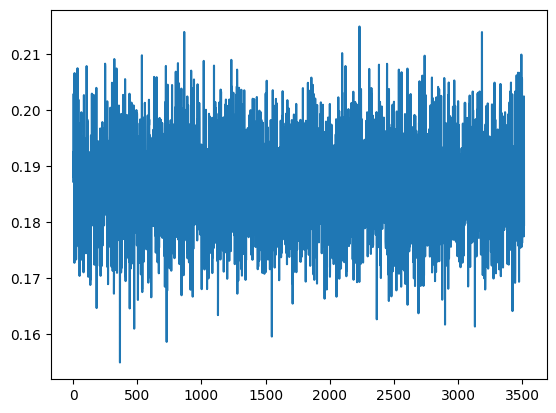

--------------------------------------

Starting main process


  0%|                                                                                                              | 0/14063 [00:00<?, ?it/s]

cuda:0 cuda:0 cuda:0


TypeError: intersect() missing 1 required positional argument: 'xyz_d'

In [268]:


loss_history = []

model = NGP_MLP( L, T, F, Nmin, Nmax, sph_coeff, hidden_dim, device=device)
optim = torch.optim.Adam(params=model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.8)

## START A NEW SESSION
sess = generate_new_session("/home/ayush/projects/nerf/model_checkpoints/ingp", "fox")



################################## TEST ON SOME IMAGES

def get_mse_and_psnr(gt, pr):
    mse = ((gt - pr)**2).mean()
    psnr = 20 * np.log10(1 / np.sqrt(mse))
    return psnr, mse

def test(session, model, test_ids, tn, tf, num_bins, directional_input, white_bgr, epoch):
    with torch.no_grad():
        for i in test_ids:
            o_, d_ = create_rays(imgs[i], poses[i], intrinsics[i])
            im  = imgs[i]
            H, W, _ = im.shape
            Ax = batchify_image_and_render(model=model,
                                   rays_o=o_,
                                   rays_d=d_,
                                   tn=tn,
                                   tf=tf,
                                   num_bins=num_bins,
                                   reduction_factor=128,
                                   device=device,
                                   directional_input=directional_input,
                                   white_bgr=white_bgr)
            Ax = Ax.reshape(H, W, 3)
            psnr, mse = get_mse_and_psnr(im, Ax)
            print(f"Test IDs: {i}       | PSNR: {psnr: .3f} | MSE :{mse: .3f}")
            Ax = (Ax.reshape(H, W, 3) * 255).astype(np.uint8)
            impath = osp.join(session.sess_dir, f"epoch-{epoch}--image-{i}.png")
            cv2.imwrite(impath, cv2.cvtColor(Ax, cv2.COLOR_RGB2BGR))
           
        
############################## WARM UP TRAINING : 
##################Train on center part of image (Needed for synthetic dataset  ####################

print("Starting warm-up")
for e in range(warmup_epochs):
    avg_loss = 0.
    for batch in tqdm(dataloader_warmup):
        BS = batch.shape[0]
        batch = batch.reshape(-1, 9)
        o = batch[:, 0:3]
        d = batch[:, 3:6]
        c = batch[:, 6:]
        Ax = render_with_perturbation(model, o, d, tn, tf, num_bins, device=device, 
                    directional_input=directional_input,white_bgr=white_bgr)        
        loss = ((Ax - c)**2).mean()
        optim.zero_grad()
        loss.backward()
        optim.step()
        loss_history.append(loss.item())
        avg_loss += loss.item()
    print(f"Epoch: {e+1}: avg_loss: {avg_loss/ len(dataloader_warmup)}")
    modelpath = osp.join(sess.sess_dir, f'model_{obj}-warmup.pth')
    torch.save(model.cpu(), modelpath)
    model.to(device)
    test(sess, model, test_ids, tn, tf, num_bins, directional_input, white_bgr, "warmup")
    plt.plot(loss_history)
    plt.show()

    
####################  MAIN TRAINING LOOP
    
print("--------------------------------------")
print("\nStarting main process")
for e in range(num_epochs):
    avg_loss = 0.
    for batch in tqdm(dataloader): 
        BS = batch.shape[0]
        batch = batch.reshape(-1, 9)
        o = batch[:, 0:3]
        d = batch[:, 3:6]
        c = batch[:, 6:]
        print(o.device, d.device, c.device)
        Ax = render_with_perturbation(model, o, d, tn, tf, num_bins, directional_input=False, device=device, white_bgr=True)        
        loss = ((Ax - c)**2).mean()
        optim.zero_grad()
        loss.backward()
        optim.step()
        loss_history.append(loss.item())
        avg_loss += loss.item()
    print(f"Epoch: {e+1}: avg_loss: {avg_loss/ len(dataloader)}")
    scheduler.step()
    modelpath = osp.join(sess.sess_dir, f'model_{obj}-epoch{e+1}.pth')
    torch.save(model.cpu(), modelpath)
    model.to(device)
    test(sess, model, test_ids, tn, tf, num_bins, directional_input, white_bgr, e)
    plt.plot(loss_history)
    plt.show()
    


In [ ]:
# Train on L

In [273]:
##

x = np.load("../assets/lego/testing_data.pkl", allow_pickle=True)
x.shape

(32000000, 9)

In [275]:
ix = x[:, 6:]
ix = ix.reshape(-1, 400, 400, 3)
ix.shape

(200, 400, 400, 3)

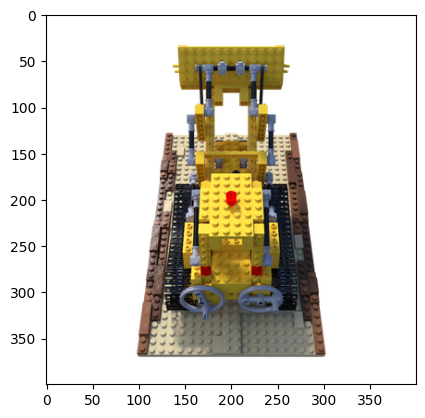

In [276]:
plt.imshow(ix[0])